# Grover's Algorithm on 1-IN-3-SAT

So far we've been focusing on fairly simple systems designed solely for observing and understanding mysterious behavior quantum mechanics. Now, we'll put our engineering hat's on and build a circuit that will actually solve a real (albeit small scale) problem. Although the problem we'll tackle is small, it is by no means easy. In fact, let's go straight for some of the hardest (yet most important) types of problems studied, a $\mathcal{NP}$-complete problem!

First, a quick recap on complexity theory, so we can really appreciate what we're about to do. Algorithms can be compared in terms of how much space (memory) or time (number of operations) they require, in terms of their input size (denoted $N$). Algorithms can be classified into different sets, for example, the set of polynomial algorithms (denoted $\mathcal{P}$) comprises of all the algorithms that require on the order of a polynomial steps in the input, denoted $\mathcal{O}(N^K)$ for some $K$. Another important set is the set of non-deterministic polynomial algorithms (denoted $\mathcal{NP}$). A subset of $\mathcal{NP}$ problems are $\mathcal{NP}$-complete, so called because any problem in $\mathcal{NP}$ can efficiently be transformed into an $\mathcal{NP}$-complete problem. 

One of the most famous unsolved problems in mathematics is "$\mathcal{P}$ vs $\mathcal{NP}$" which asks whether or not the sets $\mathcal{P}$ and $\mathcal{NP}$ are actually the same. It's hard to understate the importance of this question because if it turns out $\mathcal{P}=\mathcal{NP}$ then that would mean there exists an efficient (meaning polynomial time) algorithm to solve any $\mathcal{NP}$ problem, and many of the most interesting problems we would like to solve are in $\mathcal{NP}$. One way to prove $\mathcal{P}=\mathcal{NP}$ is to develop an efficient algorithm for any one $\mathcal{NP}$-complete problem. Currently, the only algorithms we know to solve $\mathcal{NP}$-complete problems are exponential in time ($\mathcal{O}(K^N)$ for some $K$). A very popular family of $\mathcal{NP}$-complete problems solve for satisfiability of boolean expressions, which is what we'll be investigating.

Now before you start thinking you have to solve "$\mathcal{P}$ vs $\mathcal{NP}$" for homework (but extra credit if you do, in addition to instant world fame, a Field's medal, and millions of dollars worth of prizes!), what we're actually going to do is apply Grover's algorithm to the 1-IN-3-SAT problem. Grover's algorithm takes advantage of quantum mechanics to find solutions to a problem in $\mathcal{O}(\sqrt N)$, where $N$ is the number of possibilities (eg. database size), which allows us to solve the 1-IN-3-SAT problems faster than any classical algorithm.

Only need to run it one time. 

In [1]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit import BasicAer, Aer # for simulating circuits
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram

## Quantum Boolean Logic 

Before diving in to $\mathcal{NP}$-Complete problems and quantum circuits that are several pages long, let's get an idea for boolean logic with quantum circuits. 

There are two interesting properties of quantum circuits to consider: reversibility and no cloning. Remember that all the quantum circuits (up to measurement) are in theory fully reversible. Additionally, the no-cloning theorem tells us that given a qubit in some unknown state, there's no way to duplicate the state on another qubit.

These two properties require us to use separate input and output registers (qubits), and to be careful about undoing any operations that change our input qubits for future operations. Additionally, we will employ auxiliary qubits, or "ancilla," that will store intermediate values during computation. Just as we have to be hygenic about our input register, we will have to undo our operations on the ancilla to keep their state consistent (also referred to as keeping them "clean").

With this formalism, there are a handful of common logic gates that are particularly easy to implement: `NOT`, `XOR`, and `AND`. This small set of gates is already complete, which means we can build any boolean logic circuit with these gates alone. The three functions below implement classical `AND`, `NOT`, `XOR` gates in a quantum circuit (`circ`) given the input (`a`,`b`) and output (`y`) quantum registers.

In [3]:
def AND(circ,out,a,b): # using a Toffoli gate
    circ.ccx(a,b,out)
def NOT(circ,y): # using an X gate (same output register as input)
    circ.x(y)
def XOR(circ,out,*inputs): # using 2 CNOT gates
    for i in inputs:
        circ.cx(i,out)

def init_superposition(circ, fin): # initialize our input states as superpositions, so we test all boolean inputs
    circ.h(fin)

As an example we can implement the expression $V$:

$$V = (x_2 \oplus x_1 \oplus x_0) \wedge \lnot x_2 $$

where the $x_i$s are boolean variables, and $\oplus$ is the exclusive "or" (`XOR`) operation.

A quick calculation tells us $V$ is true if and only if $x_2x_1x_0 \in \{ 001, 010 \}$. So let's confirm this by simulating the eqivalent quantum circuit using qiskit.

In [4]:
f_in = QuantumRegister(3, 'in')
f_out = QuantumRegister(1, 'out')
aux = QuantumRegister(1, 'aux')
qc = QuantumCircuit(f_in, f_out, aux)
init_superposition(qc, f_in)

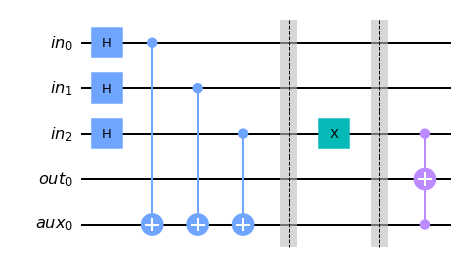

In [5]:
XOR(qc, aux[0], f_in[0], f_in[1], f_in[2])
qc.barrier()
NOT(qc, f_in[2])
qc.barrier()
AND(qc, f_out[0], aux[0], f_in[2])
qc.draw(output='mpl')

After applying all these gates, we will measure all of our qubits (including the ancilla).

In [6]:
def measure(circ, q, c=None):
    if c is None:
        c = ClassicalRegister(len(q), 'c{}'.format(q.name))
        circ.add_register(c)
    circ.measure(q,c)

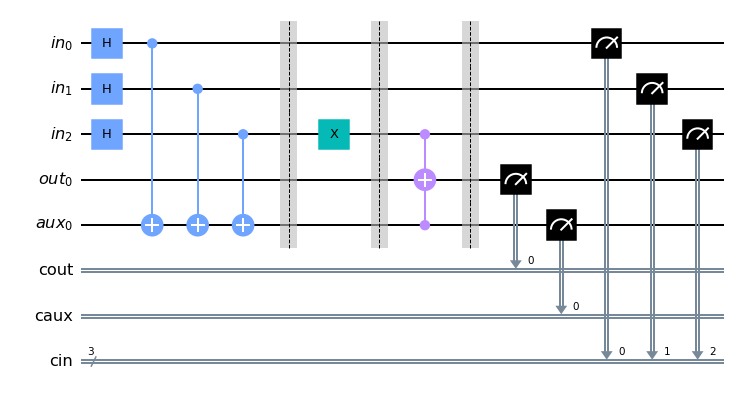

In [7]:
qc.barrier()
measure(qc, f_out)
measure(qc, aux)
measure(qc, f_in)
qc.draw(output='mpl')

Don't worry about `qiskit` having apparently moved some of the measurement operations before applying some of our gates. `qiskit` is just optimizing to measure each qubit as soon as possible to make our overall state space as small as possible, which will make the simulation more efficient. These optimizations will not change anything about the outcomes. Now we can simulate our circuit with 1000 trials using the `qasm_simulator`.

In [8]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend=backend)
result = job.result()
print('f_in aux f_out')
result.get_counts()

f_in aux f_out


{'110 1 1': 149,
 '010 0 0': 119,
 '100 0 0': 127,
 '001 0 0': 125,
 '111 0 0': 128,
 '101 1 1': 128,
 '000 1 0': 124,
 '011 1 0': 124}

In this case we are less interested in how often we get each result, and more interested in what results we get. You'll notice that there are spaces in between the binary outcomes for each bit to separate each of the registers we defined. Given the order we defined our gates, the first group of three values correspond to our input bits (`f_in`), the second number corresponds to the ancilla (`aux`), and the final number to the output bit (`f_out`). The input bits are printed in decending order ($x_2$, $x_1$, and then $x_0$).

However, you will notice there are two problems: first our ancilla are not always 0 (which means they are no longer clean), and secondly, perhaps more alarmingly, we don't get the correct results. Based on the simulator our expression evaluates to true when for inputs of 101 and 110. Both issues actually have the same cause: we didn't undo our operations.

Try rebuilding the circuit, but now, adding some gates after we write our result to the output qubit.

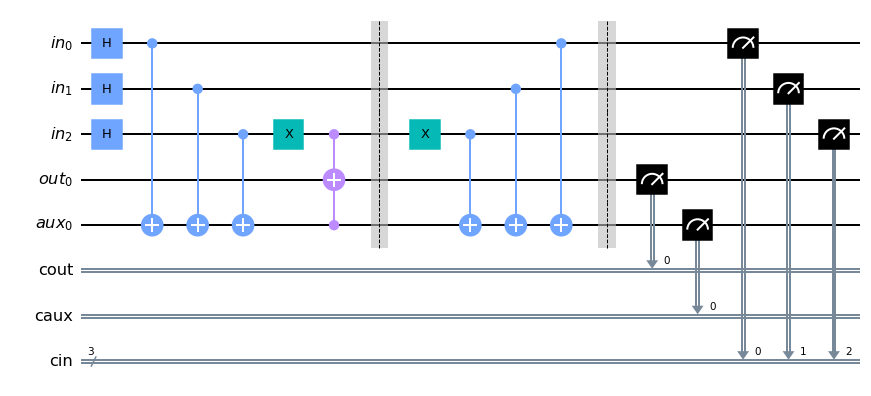

In [9]:
f_in = QuantumRegister(3, 'in')
f_out = QuantumRegister(1, 'out')
aux = QuantumRegister(1, 'aux')
qc = QuantumCircuit(f_in, f_out, aux)
init_superposition(qc, f_in)

XOR(qc, aux[0], f_in[0], f_in[1], f_in[2])
NOT(qc, f_in[2])
AND(qc, f_out[0], aux[0], f_in[2]) # Computation complete - result is "written" to f_out 
qc.barrier()

# Undo operations to input qubits and ancilla
NOT(qc, f_in[2])
XOR(qc, aux[0], f_in[2], f_in[1], f_in[0])

qc.barrier()
measure(qc, f_out)
measure(qc, aux)
measure(qc, f_in)

qc.draw(output='mpl')

In [10]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend=backend)
result = job.result()
print('f_in aux f_out')
result.get_counts()

f_in aux f_out


{'001 0 1': 129,
 '100 0 0': 124,
 '110 0 0': 138,
 '101 0 0': 128,
 '010 0 1': 125,
 '111 0 0': 119,
 '011 0 0': 127,
 '000 0 0': 134}

Note that now our ancilla is always 0, and we can recover the correct results.

The lesson here is that if want to compute an arbitrary function using a quantum circuit, we must use a separate input and output register, in addition to some number of ancilla (theoretically you only ever need a single ancilla qubit, but often the circuit can be greatly simplified by using multiple ancilla). After completing the computation of the function (meaning all necessary gates are applied to the output qubits), we have to undo the computation, by reapplying all the gates (except those that write the results to the output qubits) in reverse order.

### Problem 1: An and and and

Try implementing another simple logical expression $W$:

$$ W = x_2 \wedge \lnot x_1 \wedge x_0 $$

Hint 1: You should not need more than one ancilla in your circuit.

Hint 2: Remember to undo your computation to keep your input qubits and ancilla nice and clean. Your ancilla should always come out to zero, and the output should only be true when $x_2x_1x_0 = 101$.

In [11]:
f_in = QuantumRegister(3, 'in')
f_out = QuantumRegister(1, 'out')
aux = QuantumRegister(1, 'aux')
qc = QuantumCircuit(f_in, f_out, aux)
init_superposition(qc, f_in)

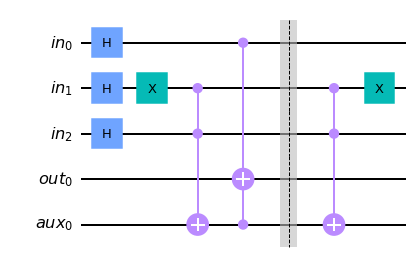

In [12]:
NOT(qc, f_in[1])
AND(qc, aux[0], f_in[2], f_in[1])
AND(qc, f_out[0], aux[0], f_in[0]) # Computation complete - result is "written" to f_out 
qc.barrier()

# Undo operations to input qubits and ancilla
AND(qc, aux[0], f_in[2], f_in[1])
NOT(qc, f_in[1])

qc.draw(output='mpl')

In [13]:
qc.barrier()
measure(qc, f_out)
measure(qc, aux)
measure(qc, f_in)
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend=backend)
result = job.result()
print('f_in aux f_out')
result.get_counts()

f_in aux f_out


{'110 0 0': 116,
 '011 0 0': 113,
 '010 0 0': 133,
 '101 0 1': 145,
 '100 0 0': 115,
 '111 0 0': 118,
 '000 0 0': 138,
 '001 0 0': 146}

## 1-IN-3-SAT

Satisfying boolean expression is a rather important problem in science and engineering. One especially interesting application, is where variables correspond to decisions and the expression might encode constraints or consequences of choices. The goal is to find an assignment of all the variables that will complete, or satisfy, the overall problem. Unfortunately, SAT, and the related 3-SAT problems are $\mathcal{NP}$-complete, so there might not exist an efficient algorithm for finding assignments to the variables which will satisfy the expression.

Just like 3-SAT, our subject, 1-IN-3-SAT, starts with a boolean expression comprising of some number of clauses using $N$ boolean variables ($x_i \in \left\{ 0,1 \right\}$). 

Let $E$ be our input expression made up of $M$ clauses, where $c_j$ is the $j$th clause, then,

$$ E = c_0 \wedge c_1 \wedge \ldots \wedge c_{M-2} \wedge c_{M-1} $$

Each clause $c_j$ is a disjunction of three variables (possibly negated). For example, $c_1$ might contain $x_0$, $x_1$, and $x_2$, so that

$$ c_1 = x_0 \vee \lnot x_1 \vee x_2 $$

where $\lnot$ is the `NOT` operator, $\wedge$ is the `AND` operator, and $\vee$ is the `OR` operator.

Given expression $E$, containing $N$ variables, we have to find the assignments of the variables ($x_i$) which will satisfy  $E$. However, so far this is just the 3-SAT problem, so there's the additional twist that in each of our clauses $c_j$ exactly one of the terms is true, while the other two must be false. These additional constraints can be encoded by transforming our example clause $c_1$ to $g_1$:

$$ g_1 = x_0 \oplus \lnot x_1 \oplus x_2 \oplus ( x_0 \wedge \lnot x_1 \wedge x_2 )$$

Now $g_1$ will only be true if $c_1$ is true, and only one of the terms ($x_0$, $\lnot x_1$, and $x_2$) are true.

Therefore, the problem in 1-IN-3-SAT is, given an expression $E$ to find assignments to our variables $x_i$ to satisfy the transformed expression $E'$:

$$ E' = g_0 \wedge g_1 \wedge \ldots \wedge g_{M-2} \wedge g_{M-1} $$

where each clause $g_j$ is the result of transforming $c_j$ as described above.

Note that our transformed clauses include only `NOT`, `AND`, and `XOR` operations, which makes this problem relatively easy to implement using common quantum gates.

Below is a function that takes in an expression $E$ and implements the corresponding $E'$ on circuit `circ` to be used in Gover's algorithm.

The expression (`expression`) that is passed in to the function must be a `list` of clauses (we'll limit ourselves to 3 clause expressions). Each clause is a list of terms in the form of integers. The value of each integer refers to the variable index, and the sign to whether or not the variable is negated.

For example, if:

$$ E = (x_1 \vee x_2 \vee \lnot x_3) \wedge (\lnot x_1 \vee \lnot x_2 \vee \lnot x_3) \wedge (\lnot x_1 \vee x_2 \vee x_3) $$

then the corresponding expression is `expression = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]`.

The correponding assignment is $x_1 = 1, x_2 = 0, x_3 = 1$, satisfy the 1-IN-3-SAT requirement. 

$$ => E = (1 \vee 0 \vee \lnot 1) \wedge (\lnot 1 \vee \lnot 0 \vee \lnot 1) \wedge (\lnot 1 \vee 0 \vee 1) $$
$$ E = (1 \vee 0 \vee 0) \wedge (0 \vee 1 \vee 0) \wedge (0 \vee 0 \vee 1) $$

## Grover's Algorithm

So far when we simulated our logic expressions, we ran many trials to get an estimate of all the possible outcomes, and then we could infer which assignments of the variables would produce an output of 1. However, if our expression is large, and comprises of many variables, then it may take exponentially (in the number of variables) many trials before we will observe a satisfying assignment (ie. the output is measured to be 1). 

Consequently, we want to increase the probability of measuring our output qubit to be 1. Grover's algorithm is an iterative algorithm which will do just that. In each step of Grover's algorithm, we first evaluate the input expression from a superposition of all possible states invert only those states we are interested in (this called applying the "oracle" operator), and then we will invert the amplitudes about the mean, which will increase the probability of measuring the desired outcome.

The `apply_oracle` function takes care of the first step, and below the function `invert_about_avg` executes the second step.

In [14]:
def apply_oracle(circ, f_in, f_out, aux, n, expression):
    num_clauses = len(expression)
    for (k, clause) in enumerate(expression):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circ.cx(f_in[literal-1], aux[k])
            else:
                circ.x(f_in[-literal-1])
                circ.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circ.ccx(f_in[0], f_in[1], aux[num_clauses])
        circ.ccx(f_in[2], aux[num_clauses], aux[k])
        circ.barrier(f_in)
        # Flip back to reverse state of negative literals and ancilla
        circ.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circ.x(f_in[-literal-1])
        circ.barrier()
        
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circ.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circ.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circ.ccx(aux[0], aux[1], aux[num_clauses])
        circ.ccx(aux[2], aux[num_clauses], f_out[0])
        circ.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(expression):
        circ.barrier()
        for literal in clause:
            if literal > 0:
                circ.cx(f_in[literal-1], aux[k])
            else:
                circ.x(f_in[-literal-1])
                circ.cx(f_in[-literal-1], aux[k])
        circ.ccx(f_in[0], f_in[1], aux[num_clauses])
        circ.ccx(f_in[2], aux[num_clauses], aux[k])
        circ.barrier(f_in)
        circ.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circ.x(f_in[-literal-1])

In [15]:
def CnX(circ, ctrls, target, clean_aux=None):
    assert len(ctrls) >= 1, 'No control qubits specified'
    if not isinstance(ctrls, list):
        ctrls = tuple(ctrls)
    if len(ctrls) == 1:
        try:
            circ.cx(ctrls[0], target[0])
        except:
            circ.cx(ctrls[0], target)
    elif len(ctrls) == 2:
        try:
            circ.ccx(ctrls[0], ctrls[1], target[0])
        except:
            circ.ccx(ctrls[0], ctrls[1], target)
    else:
        aux = clean_aux
        if aux is None or len(aux) != len(ctrls)-2:
            print('Did not receive the right number of ancillae - automatically creating new ones: got {}, need {}'.format(len(aux),len(ctrls)-2))
            aux = QuantumRegister(len(ctrls)-2, 'aux')
            circ.add_register(aux)
            aux = list(aux)
        if not isinstance(aux, list):
            aux = list(aux)
        a,b,y = ctrls.pop(), ctrls.pop(), aux.pop()
        circ.ccx(a,b,y)
        ctrls.append(y)
        CnX(circ, ctrls, target, aux)
        circ.ccx(a,b,y)
        
def CnZ(circ, ctrls, target, clean_aux=None):
    circ.h(target)
    CnX(circ, ctrls, target, clean_aux)
    circ.h(target)
        
def invert_about_avg(circ, bits, aux=None):
    try:
        bits[1:]
        gbits = bits
    except:
        gbits = tuple(bits)
    circ.h(bits)
    circ.x(bits)
    circ.barrier(bits)
    CnZ(circ, gbits[:-1], gbits[-1], aux)
    circ.barrier(bits)
    circ.x(bits)
    circ.h(bits)
    
def init_grover(circ, fin, fout):
    circ.h(fin)
    circ.x(fout)
    circ.h(fout)

Let first understand each step of this circuit of Grover's algorithm. The example circuit below has 3 input variables and 1 expression. We will only perform one iteration of Grover's algorithm on this example. 

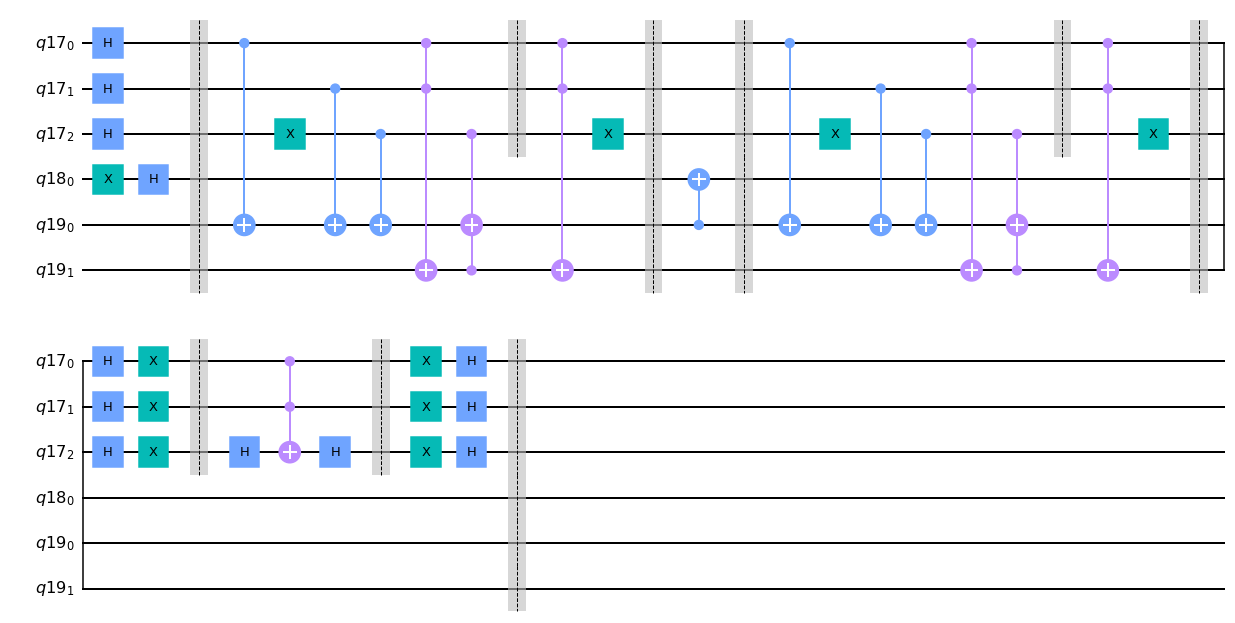

In [16]:
n = 3
expression = [[1, 2, -3]]

f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(expression) + 1) # our oracle requires n+1 ancilla
circ = QuantumCircuit(f_out, f_in, aux)

grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)

T = 1 # number of steps to take

init_grover(grover, f_in, f_out)
for t in range(T):
    grover.barrier()
    apply_oracle(grover, f_in, f_out, aux, n, expression)
    grover.barrier()
    invert_about_avg(grover, f_in, aux)
grover.barrier()
grover.draw(output='mpl')

The following steps corresponding to each big block in the circuit diagram above:

1. Initialize the input qubits and output qubit of Grover's algorithm
2. Apply $\hat{V}$ (oracle reflection transformation) with 1st expression to the input qubits. The rest of the circuit (separated by a small barrier) will flip back the input qubits to make sure state is consistent. (FYI, there will be 2nd, 3rd, ... expressions if we do have them) 
3. Apply the result to the output qubit.
4. Flip back everything we did in step 2.
5. Apply $\hat{W}$ (invert and average transformation) to the input qubits. Notice the flip backs separate by small barriers. 

Now we can put all the steps together and build the circuit that applies Grover's algorithm to the desired expression to solve the 1-IN-3-SAT problem.

In [17]:
n = 3
expression = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(expression) + 1) # our oracle requires n+1 ancilla
circ = QuantumCircuit(f_out, f_in, aux)

grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)

Since Grover's algorithm is iterative we can choose how many steps to take before measuring. It turns out, that we actually have to be careful not to take too many steps, which will cause overrotation, which means our desired outcomes actually become less likely again.

In [18]:
T = 2 # number of steps to take

init_grover(grover, f_in, f_out)
for t in range(T):
    grover.barrier()
    apply_oracle(grover, f_in, f_out, aux, n, expression)
    grover.barrier()
    invert_about_avg(grover, f_in, aux)

Since we are actually only interested in the assignments of the input variables, we don't even have to measure the output qubit.

In [19]:
grover.barrier()
measure(grover, f_in)

Now we can simulate our circuit, and run many trials to get an idea of how likely each outcome is. This is a fairly large circuit, so don't worry if the simulator needs a couple seconds.

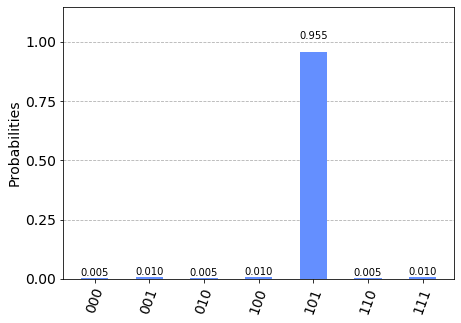

In [20]:
# Execute circuit
backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=200)
result = job.result()
counts = result.get_counts(grover)
plot_histogram(counts)

As you can see, we measure the outcome 101 more than of the time. The corresponding assignment does in fact satisfy the expression just like we wanted.

We can also see just how large our circuit actually is. Considering we have to apply our oracle gate once for each step, all the while making sure to keep our ancilla and input clean, you might not be surprised how large our gate can get.

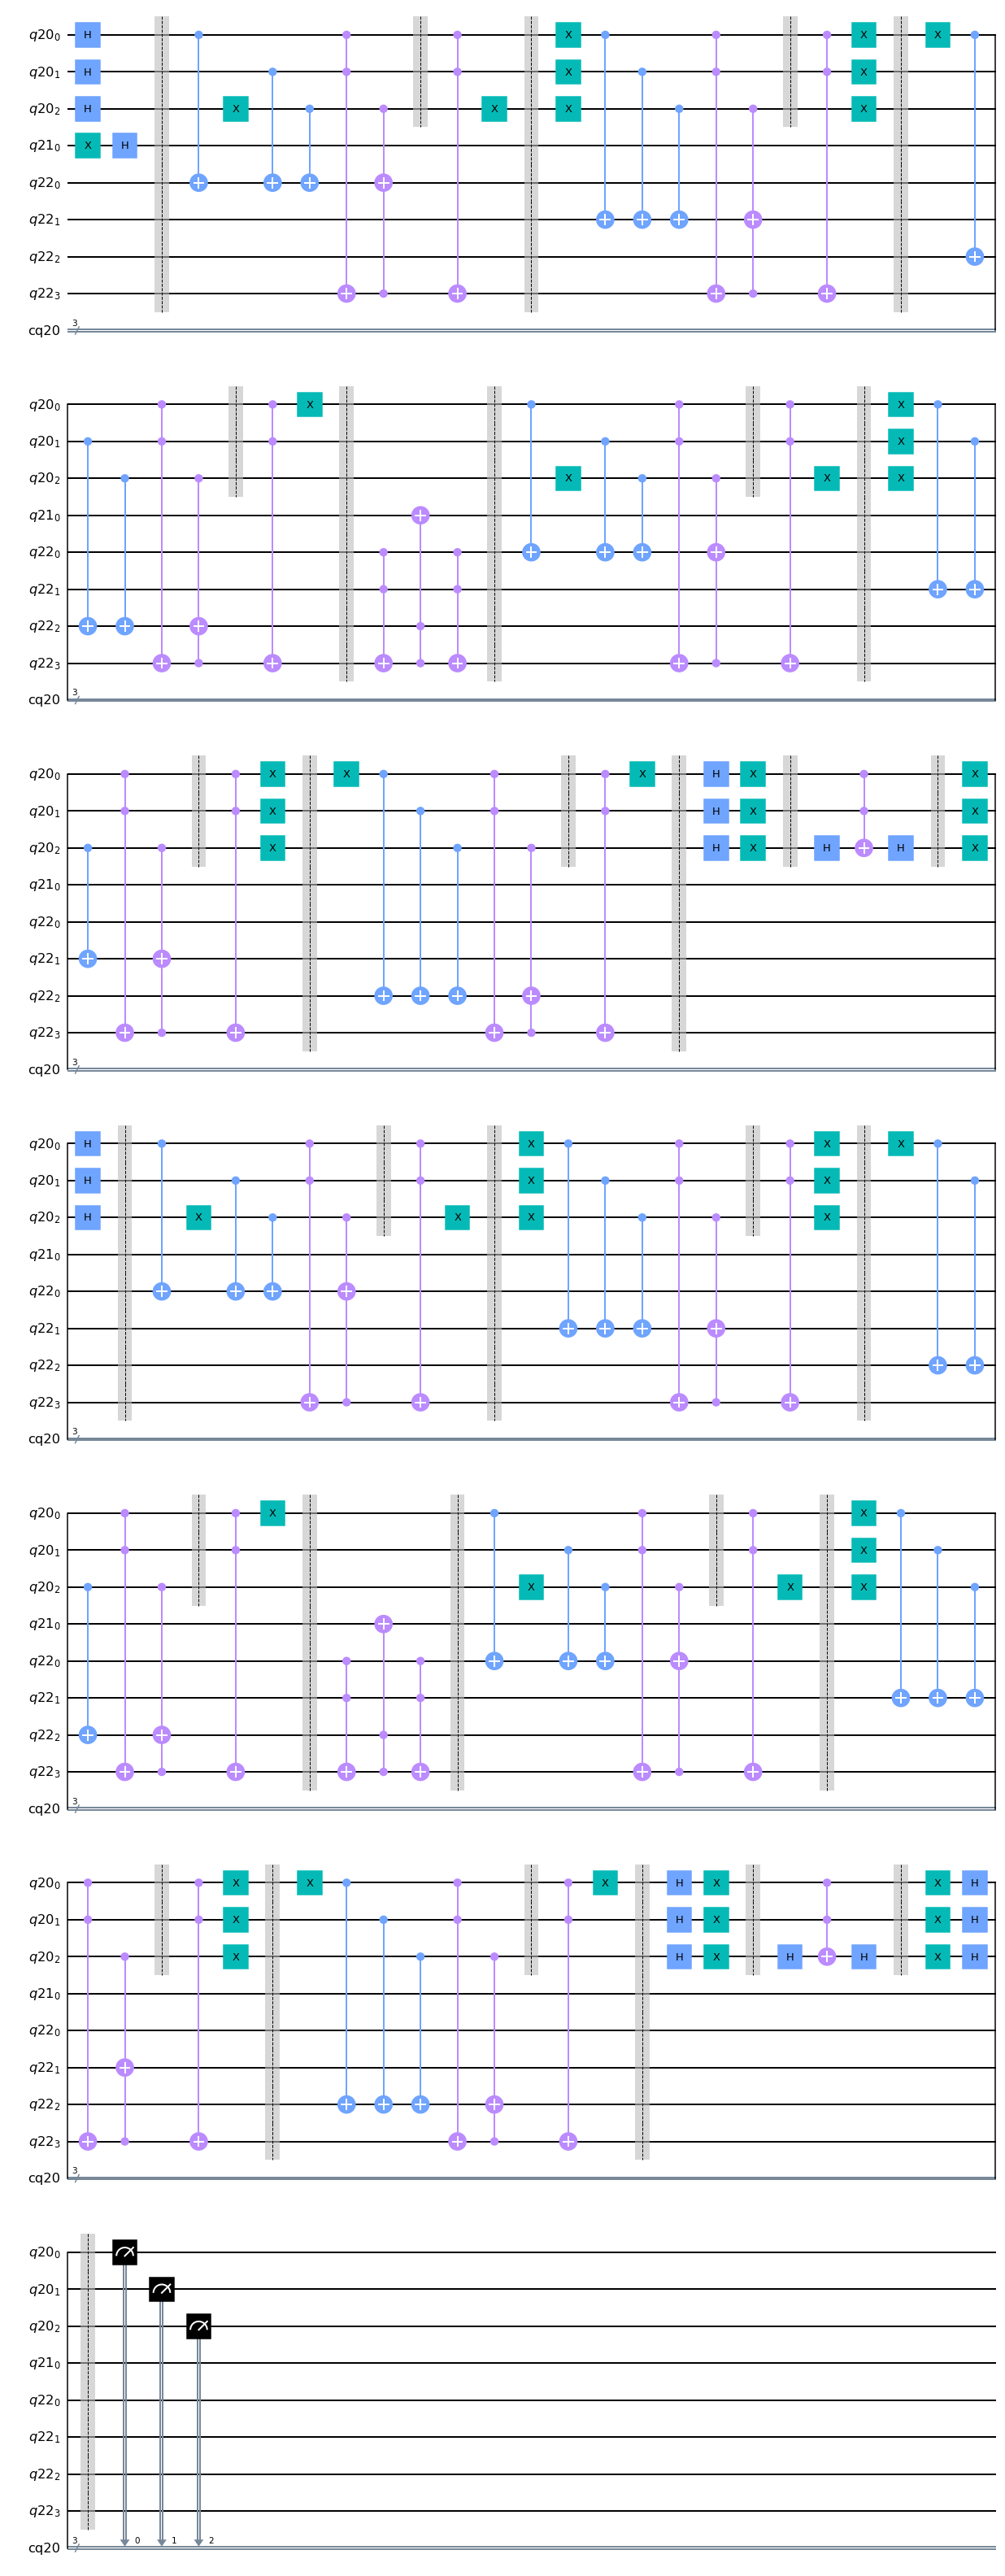

In [21]:
grover.draw(output='mpl')

### Problem 2: Solving 1-IN-3-SAT

Given:

$$ F = (x_1 \vee \lnot x_2 \vee \lnot x_3) \wedge (\lnot x_1 \vee x_2 \vee \lnot x_3) \wedge (x_1 \vee x_2 \vee x_3) $$

First, use Grover's algorithm to solve the 1-IN-3-SAT problem for $F$, that is, find an assignment of $x_1$, $x_2$, and $x_3$ that will satisfy the expression $F$, given that only a single term in each expression can be true.

Try running the circuit using 1, 2 and 4 steps, and report the probabilities of all outcomes each time. How do the results change when you change the timesteps? Why do they change in that way?

In [22]:
n = 3
expression = [[1, -2, -3], [-1, 2, -3], [1, 2, 3]]

f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(expression) + 1) # our oracle requires n+1 ancilla
circ = QuantumCircuit(f_out, f_in, aux)

grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)

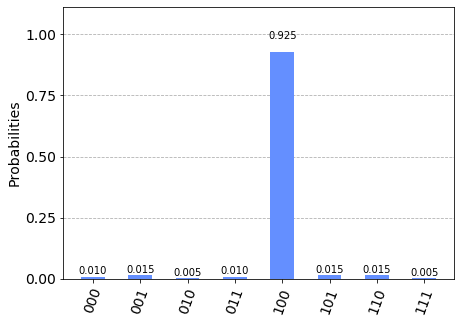

In [23]:
T = 2 # number of steps to take

init_grover(grover, f_in, f_out)
for t in range(T):
    apply_oracle(grover, f_in, f_out, aux, n, expression)
    invert_about_avg(grover, f_in, aux)
measure(grover, f_in)

# Execute circuit
backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=200)
result = job.result()
counts = result.get_counts(grover)
plot_histogram(counts)

T = 1 {'100' = 0.780}; 
T = 2 {'100' = 0.955}; 
T = 4 {'100' = 0.005}; 

When timesteps change from 1 to 2, the result probabilities increase. But when timesteps change from 2 to 4, the result probabilities decrease. 

Timestep 1 is too less for the result probabilities to reach nearly 100%. Timestep 2 is perfect for about 100% the result probabilities. Then Timestep 4 will cause overrotation, which makes the result probabilities become less likely again.

### Problem 3: 6-bit Grover's Algorithm (for EE 521 only)

We define eight phone number $ p_1=000,p_1=001,p_3=010, ... p_{8}=111 $ and the names corresponding to the phone numbers are $ n_1=000,n_1=001,n_3=010, ... n_{8}=111 $ respectively. Recall that in Grover’s algorithm, the phone numbers are stored in three qubits and the name are stored in three other qubits. In terms of qubit states, the phone numbers are $ | p_1 \rangle =| 000\rangle, | p_2 \rangle=| 001\rangle, | p_3 \rangle=| 010\rangle, ... | p_{8} \rangle=| 111\rangle $ and the corresponding names stored on three other qubits are $ | p_1 \rangle =| 000\rangle, | p_2 \rangle=| 001\rangle, | p_3 \rangle=| 010\rangle, ... | p_{8} \rangle=| 111\rangle $. The phone numbers are identical to the names which are stored on three other qubits. Starting out with the state $ | 000000\rangle=| 000\rangle| 000\rangle, $  find the gate operations to reach the following states in the Grover’s algorithm sequentially:

(a) $ | init\rangle=\frac{1}{\sqrt{8}} [| 000\rangle| p_1 \rangle+| 001\rangle| p_2 \rangle+| 010\rangle| p_3 \rangle+ ... +| 111\rangle| p_{8} \rangle] $  
(b) $ \hat{V}| init\rangle=-\frac{1}{\sqrt{8}} | 110,p_7 \rangle + \frac{\sqrt{7}}{\sqrt{8}}[\frac{1}{\sqrt{7}} (| 000,p_1 \rangle+| 001,p_2 \rangle+| 010,p_3 \rangle + ...)] $  
(c) $ \hat{W}\hat{V}| init\rangle=\frac{5}{4\sqrt{2}}| 110\rangle| p_7 \rangle + \frac{\sqrt{7}}{4\sqrt{2}}[\frac{1}{\sqrt{7}} (| 000,p_1 \rangle+| 001,p_2 \rangle+| 010,p_3 \rangle + ...)]$  
(d) repeat above operations

Implement the above gates in qiskit and confirm that your realization is correct. What is the optimum number of rotations for this search problem in term of operations by $ \hat{W}\hat{V}$ ?


Hint: You can refer to Lecture note 7.5.2 section 


In [45]:
def init(qc, n, p, inverse=False):
    if inverse:
        qc.cx(n[2], p[2])
        qc.cx(n[1], p[1])
        qc.cx(n[0], p[0])
        qc.h(n)
    else: 
        qc.h(n)
        qc.cx(n[0], p[0])
        qc.cx(n[1], p[1])
        qc.cx(n[2], p[2])
    qc.barrier()

def V(qc, n):
    qc.x(n[0])
    qc.h(n[2])
    qc.ccx(n[0], n[1], n[2])
    qc.h(n[2])
    qc.x(n[0])
    qc.barrier()

def W(qc, n):
    qc.x(n)
    qc.h(n[2])
    qc.ccx(n[0], n[1], n[2])
    qc.h(n[2])
    qc.x(n)
    qc.barrier()
    
def W_minus(qc, n, p):
    init(qc, n, p, inverse=True)
    W(qc, n)
    init(qc, n, p)
    
def W_6bit(qc, n, p):
    qc.h(n)
    qc.h(p)
    qc.x(n)
    qc.x(p)
    qc.h(n[2])
    qc.mcx([n[0], n[1], p[0], p[1], p[2]], n[2])
    qc.h(n[2])
    qc.x(p)
    qc.x(n)
    qc.h(n)
    qc.h(p)
    qc.barrier()

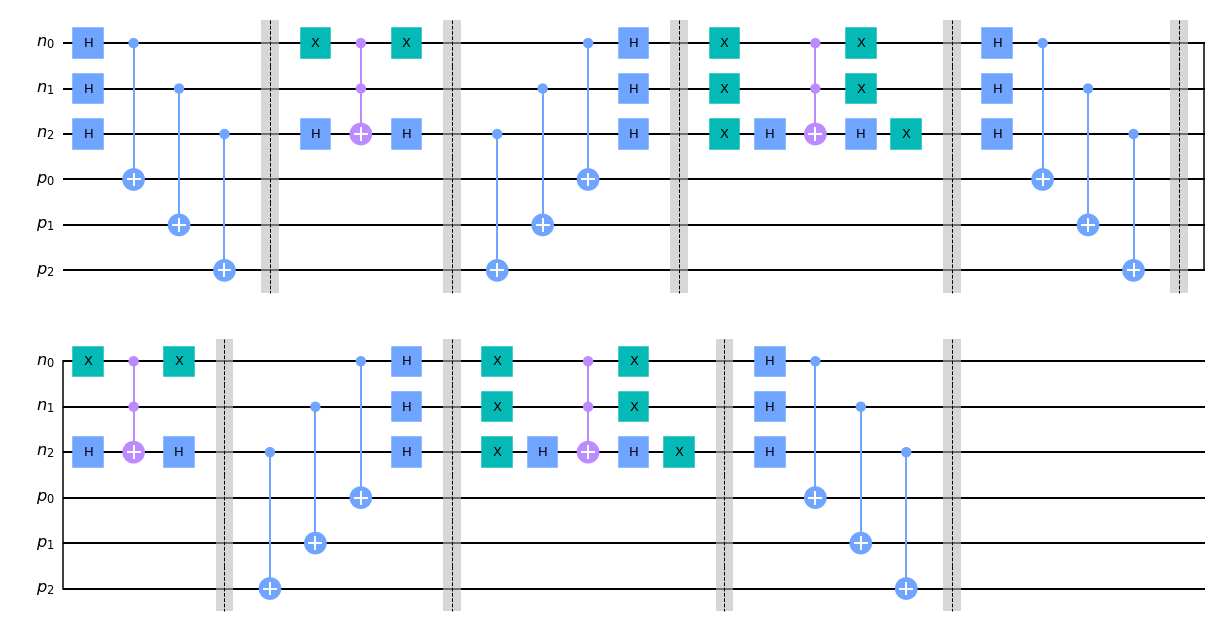

In [56]:
n = QuantumRegister(3, 'n')
p = QuantumRegister(3, 'p')
qc = QuantumCircuit(n, p)

init(qc, n, p)
V(qc, n)
# W_6bit(qc, n, p)
W_minus(qc, n, p)

V(qc, n)
# W_6bit(qc, n, p)
W_minus(qc, n, p)

# V(qc, n)
# W_6bit(qc, n, p)
qc.draw(output='mpl')

In [57]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
outputstate = result.get_statevector(qc, decimals=64)
print(outputstate)

[ 0.08838835-4.10258525e-16j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.08838835-3.68008745e-16j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.08838835-4.39023687e-16j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.08838835-3.12127746e-16j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0

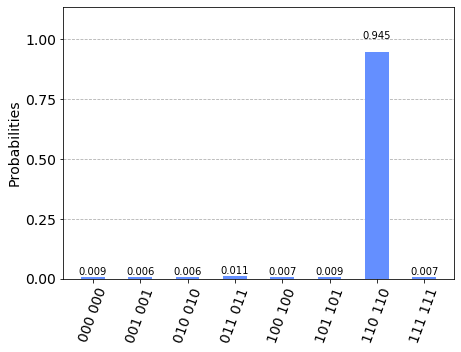

In [58]:
measure(qc, n)
measure(qc, p)
backend = BasicAer.get_backend('qasm_simulator')
job = execute([qc], backend=backend, shots=2000)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

## Should we alert the press?

Quantum algorithms can provide an exponential speedup, compared to any known classical algorithm, for some problems. The problem we investigated here, 1-IN-3-SAT, is an $\mathcal{NP}$-complete problem, which means if we can efficiently solve it, then we can efficiently solve any $\mathcal{NP}$ problem (which includes a lot of very important, very interesting problems).

We don't know of any classical algorithm that can solve the 1-IN-3-SAT problem in faster than in exponential time ($\mathcal{O}(K^N)$) where $N$ is the number of variables.

Meanwhile, Grover's algorithm lets us search a space of size $N$ samples in on the order of $\mathcal{O}(\sqrt N)$ time. This means we can run Grover's algorithm in polynomial time (with respect to $N$).

This begs the question: Did we just find an algorithm that can solve an $\mathcal{NP}$-complete problem in polynomial time? If so, we have to alert the press right away - we just made history!!

### Problem 3: Fast, but is it fast enough?

Just what kind of speedup did applying Grover's algorithm give us (assuming we ran our circuit on a real quantum computer rather than just a simulator)? Did we find a polynomial time algorithm to solve 1-IN-3-SAT?

Hint: Remind yourself what the definitions of $N$ is for each of the running times above, how do they relate?

N means the times we need to built the oracle quantum circiuts and Grover's Algorithm circiuts. If the N is very large, we will need to built a extremly large circuit. 